In [1]:
!pip install pyDOE 

Looking in indexes: https://pypi.mirrors.ustc.edu.cn/simple/


In [2]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from torch.autograd import grad
from pyDOE import lhs
import random
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.ticker as ticker

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype=torch.float32
torch.set_default_dtype(dtype)





def setup_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cuda.matmul.allow_tf32 = False
        torch.backends.cudnn.allow_tf32 = False
    
setup_seed(1234)









class ResBlock(nn.Module):
    def __init__(self, n_node):
        super(ResBlock, self).__init__()
        self.linear0 = torch.nn.Linear(n_node, n_node)
        self.linear1 = torch.nn.Linear(n_node, n_node)
        self.activation = torch.nn.GELU()
        nn.init.xavier_normal_(self.linear0.weight)
        nn.init.constant_(self.linear0.bias, 0)
        nn.init.xavier_normal_(self.linear1.weight)
        nn.init.constant_(self.linear1.bias, 0)

        

    def forward(self, x):
        out = self.linear0(x)                   
        out = self.activation(out)
        out = out+x

        return out
        
        
class ResBolck2L(torch.nn.Module):
    ''' ResBlock2L：
    net = ResBlock2L(dim_1,dim_2)
    net.forward: x+layers2(layers1(x))
    '''
    def __init__(self,dim_1,dim_2,act=None):
        super().__init__()
        self.layer_1 = torch.nn.Linear(dim_1,dim_2)
        self.layer_2 = torch.nn.Linear(dim_2,dim_1)
        self.act = torch.nn.functional.gelu if act == None else act
    
    def forward(self,x):
        return x + self.act(self.layer_2(self.act(self.layer_1(x))))        
        
        


class NetResDeep(nn.Module):
    def __init__(self, dim_in, dim_out, n_block, n_node,ub, lb):
        super().__init__()
        self.fc1 = nn.Linear(dim_in, n_node)
        self.activation = torch.nn.GELU()
        self.resblocks = nn.Sequential(*[ResBlock(n_node=n_node) for _ in range(n_block)])
        self.fc2 = nn.Linear(n_node, dim_out)
        self.ub = torch.tensor(ub, dtype=torch.float).to(device)
        self.lb = torch.tensor(lb, dtype=torch.float).to(device)
        
    def forward(self, x):
        out = x
        out = self.fc1(out)
        out=self.activation(out)
        out = self.resblocks(out)
        out = self.fc2(out)
        return out



def weights_init(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.zeros_(m.bias.data)

def rhs(x):

    # Right-Hand-Side of the Poisson equation
        return 2*torch.exp(-((x[:,0:1]-0.5)**2)/(2*h*h))+((((x[:,0:1]-0.5)**2)/(1*h*h)-1)*(x[:,1:2]**2+1000)*torch.exp(-((x[:,0:1]-0.5)**2)/(2*h*h)))/h**2
        
  

def u_r(x):

    # Right-Hand-Side of the Poisson equation
        return 1+(1000+(x[:,1:2])**2)*np.exp(-(x[:,0:1]-0.5)**2/(2*h*h))


# Parameters

x_min = 0
x_max = 1
y_min = 0
y_max = 1
h = 0.05


ub = np.array([x_max, y_max])
lb = np.array([x_min, y_min])


N_bc = 300
N_f = 10000

########


x_points = lambda n: np.random.uniform(x_min, x_max, (n, 1))
y_points = lambda n: np.random.uniform(y_min, y_max, (n, 1))





# collocation points

class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()

        self.net=NetResDeep( dim_in=2, dim_out=1, n_block=3, n_node=50, ub=ub, lb=lb).to(device)
        self.iter = 0
        self.optimizer = torch.optim.LBFGS(
            self.net.parameters(),
            lr=1,
            max_iter=50000,
            max_eval=50000,
            history_size=200,
            tolerance_grad=1e-12, 
            tolerance_change=1.0 * np.finfo(float).eps,
            line_search_fn="strong_wolfe",
        )
        self.adam = torch.optim.Adam(self.net.parameters(), lr=2e-3)
        self.scheduler=torch.optim.lr_scheduler.StepLR(self.adam,step_size=30,gamma=0.99)
        self.losses = {"loss": [], "bc": [], "pde": []}
        
    
    def loss_bc(self, xyt):
        u = self.net(xyt)
        mse_bc = torch.mean(torch.square(u - u_bc))
        return mse_bc

    def loss_pde(self, xyt):
        xy = xyt.clone()
        xy.requires_grad = True

        u = self.net(xy)
        u_xyt = grad(u.sum(), xy, create_graph=True)[0]
        u_xx = grad(u_xyt[:, 0:1].sum(), xy, create_graph=True)[0][:, 0:1]
        u_yy = grad(u_xyt[:, 1:2].sum(), xy, create_graph=True)[0][:, 1:2]
        pde =-rhs(xy)+u_xx + u_yy
        
        mse_pde = torch.mean(torch.square(pde))
        return mse_pde

    def closure(self):
        self.optimizer.zero_grad()
        self.adam.zero_grad()
        mse_bc = self.loss_bc(xy_bc)
        mse_pde = self.loss_pde(xy_f)


        loss = mse_bc + mse_pde

        
        loss.backward()
        
        self.losses["loss"]=loss.detach().cpu().item()
        self.losses["bc"]=mse_bc.detach().cpu().item()
        self.losses["pde"]=mse_pde.detach().cpu().item()
        
        
        
        if self.iter % 1000 == 0:
            
            print(f"{self.iter} Loss: {loss.item():.5e}  BC: {mse_bc.item():.5e} pde:{mse_pde.item():.5e}")
        self.iter += 1
        return loss


    
    
   
if __name__ == "__main__":

    pinn = PINN()
    
    
    
    
    x_bc1 = np.ones((N_bc, 1))*x_min
    y_bc1 = y_points(N_bc)
    


    x_bc2 = np.ones((N_bc, 1)) * x_max
    y_bc2 = y_points(N_bc)

    x_bc3 = x_points(N_bc)
    y_bc3 = np.ones((N_bc, 1))*y_min


    x_bc4 = x_points(N_bc)
    y_bc4 = np.ones((N_bc, 1)) * y_max
    

    x_bc = np.vstack([x_bc1, x_bc2, x_bc3, x_bc4])
    y_bc = np.vstack([y_bc1, y_bc2, y_bc3, y_bc4])
    xy_bc = np.hstack([x_bc, y_bc])
    u_bc = u_r(xy_bc)


   # collocation points
    x_f = x_min + (x_max - x_min) * lhs(1, N_f)
    y_f = y_min + (y_max - y_min) * lhs(1, N_f)
    xy_f = np.hstack([x_f, y_f])
    xy_f = np.vstack([xy_f, xy_bc])


    xy_bc = torch.tensor(xy_bc, dtype=dtype).to(device)
    u_bc = torch.tensor(u_bc, dtype=dtype).to(device)
    xy_f = torch.tensor(xy_f, dtype=dtype).to(device)
    
    for i in range(5000):
        pinn.closure()
        pinn.adam.step()
        pinn.scheduler.step()
    pinn.optimizer.step(pinn.closure)
    
    print(f"{pinn.iter} Loss: {pinn.losses['loss']:.5e}  BC: {pinn.losses['bc']:.5e} pde: {pinn.losses['pde']:.5e}")
    
    
    #torch.save(pinn.state_dict(), 'multi-normal.pt') 
    
    
    

/root/miniconda3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


0 Loss: 1.01197e+10  BC: 4.77821e+04 pde:1.01197e+10
1000 Loss: 4.55042e+07  BC: 2.85014e+05 pde:4.52192e+07
2000 Loss: 3.27798e+06  BC: 2.03024e+04 pde:3.25768e+06
3000 Loss: 2.75436e+06  BC: 1.89766e+04 pde:2.73538e+06
4000 Loss: 5.15777e+05  BC: 1.86797e+04 pde:4.97097e+05
5000 Loss: 3.49800e+05  BC: 1.83855e+04 pde:3.31415e+05
6000 Loss: 2.90531e+04  BC: 8.64445e+03 pde:2.04087e+04
7000 Loss: 9.61408e+03  BC: 2.32247e+03 pde:7.29161e+03
8000 Loss: 2.78290e+03  BC: 1.89694e+01 pde:2.76393e+03
8900 Loss: 1.26480e+03  BC: 3.91743e+01 pde: 1.22562e+03


Text(0, 0.5, 'y')

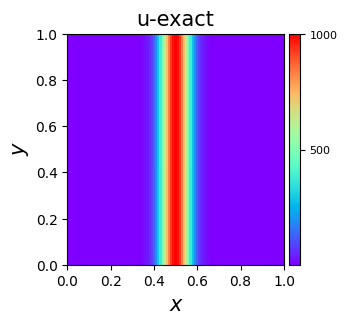

In [3]:
X0,Y0 = np.meshgrid(np.linspace(0,1,101),np.linspace(0,1,101))
Z0 = 1+(1000+(Y0)**2)*np.exp(-(X0-0.5)**2/(2*h*h))
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(Z0, interpolation='nearest', cmap='rainbow', 
            extent=[0, 1, 0, 1], 
            origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(2)# colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('u-exact',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')


Text(0, 0.5, 'y')

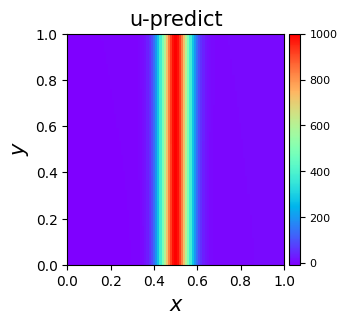

In [4]:
tX,tY = torch.tensor(X0,dtype=torch.float32,device=device),torch.tensor(Y0,dtype=torch.float32,device=device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([tX.reshape(-1,1),tY.reshape(-1,1)],dim=1)).reshape(101,101)
U0 = tZ.cpu().numpy()
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(U0, interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8) 
ax.set_title('u-predict',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')

    

#plt.savefig('./pic/3_err_6-10.pdf', format='pdf', bbox_inches='tight')    

Text(0, 0.5, 'y')

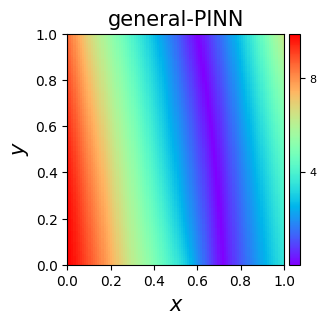

In [5]:
fig = plt.figure(figsize=(3, 3))
ax = fig.add_subplot(111)
hh = ax.imshow(abs(Z0-U0), interpolation='nearest', cmap='rainbow', 
              extent=[0, 1, 0, 1], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(hh, cax=cax)
cbar.ax.tick_params(labelsize=8) 
tick_locator = ticker.MaxNLocator(nbins=2)  # colorbar上的刻度值个数
cbar.locator = tick_locator
ax.set_title('general-PINN',fontsize=15)
ax.set_xlabel('x', fontsize=15,fontfamily = 'sans-serif',fontstyle='italic')
ax.set_ylabel('y', fontsize=15,fontstyle='oblique')


In [6]:
err=torch.from_numpy(Z0-U0)
u_norm=torch.from_numpy(U0)
error_vec_1 = torch.linalg.vector_norm(err,float('inf')).numpy()
error_vec_2 = (torch.linalg.vector_norm(err,2)/torch.linalg.vector_norm(u_norm,2)).numpy()
error_vec_3 = (torch.linalg.vector_norm(err,1).numpy())/err.numel()
print(f"L_2 error: {error_vec_2:.3e}")
print(f"L_inf error: {error_vec_1:.3e}")
print(f"L_1 error: {error_vec_3:.3e}")

L_2 error: 1.608e-02
L_inf error: 9.917e+00
L_1 error: 3.952e+00


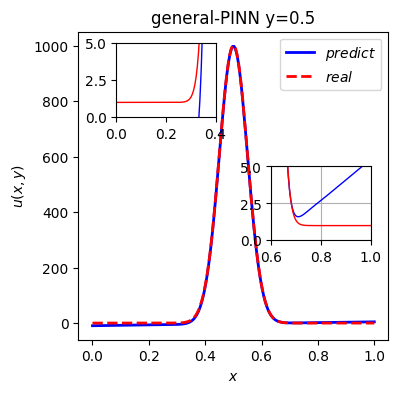

In [7]:
x_min=1.0

x=torch.linspace(0,x_min,200).to(device)
y=0.5*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.5*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([x_r.reshape(-1,1), y_r.reshape(-1,1)]))





fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')
#ax.plot(xt_a[:,0:1],y_a , 'r*', linewidth = 2, label = '$data$')

axins = inset_axes(ax, width="40%", height="30%", loc='lower left',
                   bbox_to_anchor=(0.1, 0.7, 0.8, 0.8),
                   bbox_transform=ax.transAxes)

axins.plot(x_r,U0, color='b', linestyle='-', linewidth=1, markersize=5,
            markeredgecolor='black', markerfacecolor='C0')

axins.plot(x_r,u , color= 'r', linestyle='-', linewidth=1,markersize=5,
            markeredgecolor='black', markerfacecolor='C3')
axins.set_xlim(0, 0.40)
axins.set_ylim(0, 5)



axins1 = inset_axes(ax, width="40%", height="30%", loc='lower left',
                   bbox_to_anchor=(0.6, 0.3, 0.8, 0.8),
                   bbox_transform=ax.transAxes)

axins1.plot(x_r,U0, color='b', linestyle='-', linewidth=1, markersize=5,
            markeredgecolor='black', markerfacecolor='C0')

axins1.plot(x_r,u , color= 'r', linestyle='-', linewidth=1,markersize=5,
            markeredgecolor='black', markerfacecolor='C3')
axins1.set_xlim(0.6, 1)
axins1.set_ylim(0, 5)






ax.set_xlabel('$x$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('general-PINN y=0.5')
plt.grid()
ax.legend()
#plt.savefig('./pic/7-0-normal.pdf', format='pdf', bbox_inches='tight') 

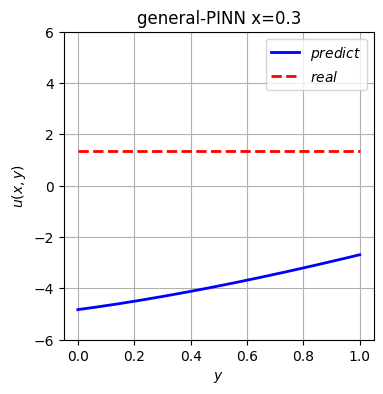

In [8]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.3*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.3*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')


ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('general-PINN x=0.3')

ax.set_ylim([-6.0,6.0])    

plt.grid()
ax.legend()
#plt.savefig('./pic/7-x3-normal.pdf', format='pdf', bbox_inches='tight') 

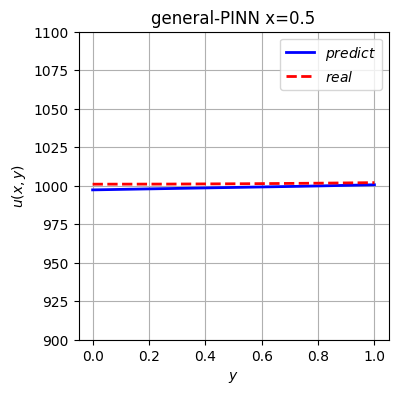

In [9]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.5*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.5*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')

ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('general-PINN x=0.5')
ax.set_ylim([900,1100])    
plt.grid()
ax.legend()
#plt.savefig('./pic/7-x5-normal.pdf', format='pdf', bbox_inches='tight') 

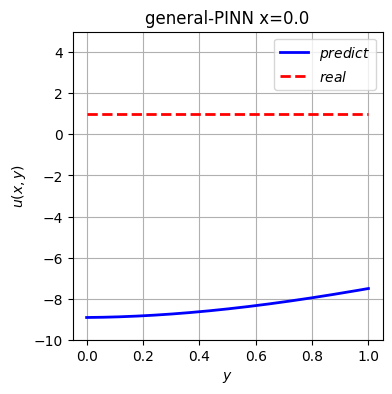

In [10]:
x_min=1.0

y=torch.linspace(0,x_min,200).to(device)
x=0.0*torch.ones_like(x).to(device)
with torch.inference_mode(1):tZ = pinn.net(torch.cat([x.reshape(-1,1),y.reshape(-1,1)],dim=1))
U0 = tZ.cpu().numpy()


x_r=np.linspace(0,x_min,200)
y_r=0.0*np.ones_like(x_r)
#h=0.03
u = u_r(np.hstack([y_r.reshape(-1,1), x_r.reshape(-1,1)]))


fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(111)
ax.plot(x_r,U0, 'b-', linewidth = 2, label = '$predict$')
ax.plot(x_r,u , 'r--', linewidth = 2, label = '$real$')

ax.set_xlabel('$y$')
ax.set_ylabel('$u(x,y)$')    
ax.set_title('general-PINN x=0.0')
ax.set_ylim([-10.0,5])    
plt.grid()
ax.legend()
#plt.savefig('./pic/7-x0-normal.pdf', format='pdf', bbox_inches='tight') 